<center>
<h1> SOLUCIÓN TAREA 4</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>


In [1]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance,standard_deviation,mean
from scipy.stats import variation

import cv2
from IPython.display import Image
import numpy as np
from matplotlib import pyplot as plt

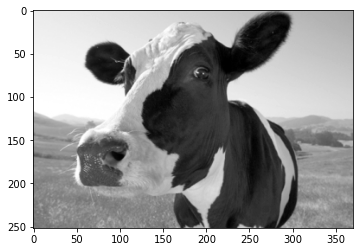

In [371]:
#img = cv2.imread('fig/fig.png',0)
img = cv2.imread('fig/img.jpg',0)
plt.imshow(img,cmap='gray')

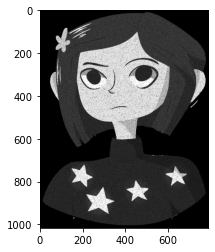

In [269]:
gauss = np.random.normal(0,0.6,img.size)
gauss = gauss.reshape(img.shape[0],img.shape[1]).astype('uint8')
noise_img = img + img * gauss

plt.imshow(noise_img,cmap='gray')

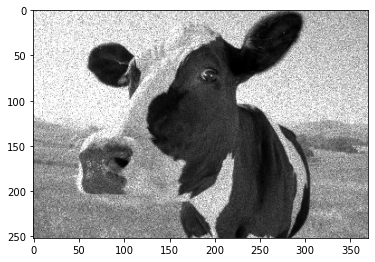

In [375]:
from skimage.util import random_noise
noise_img = random_noise(img, mode='speckle',mean=0,var=0.02)
# The above function returns a floating-point image
# on the range [0, 1], thus we changed it to 'uint8'
# and from [0,255]
noise_img = np.array(255*noise_img, dtype = 'uint8')
cv2.imwrite('fig/img_n.jpg',noise_img)
# Display the noise image
plt.figure(1,figsize=[6,6])
plt.imshow(noise_img,cmap='gray')

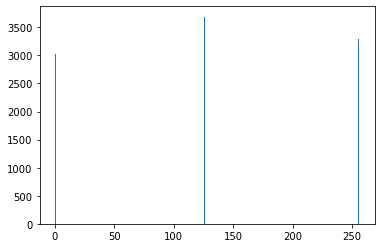

In [161]:
plt.hist(np.abs(img).ravel(),256,[0,256])
plt.show()

<h1>PRIMER PUNTO</h1> Implementar, en OpenCV, tres de los filtros para reducción de ruido Speckle vistos en clase.

In [382]:
def assert_indices_in_range(width, height, xleft, xright, yup, ydown):
    """
    Asserts index out of image range.
    """
    assert xleft >= 0 and xleft <= width, \
        "index xleft:%s out of range (%s<= xleft < %s)" % (xleft, 0, width)

    assert xright >= 0 and xright <= width, \
        "index xright:%s out of range (%s<= xright < %s)" % (xright, 0, width)

    assert yup >= 0 and yup <= height, \
        "index yup:%s out of range. (%s<= yup < %s)" % (yup, 0, height)

    assert ydown >= 0 and ydown <= height, \
        "index ydown:%s out of range. (%s<= ydown < %s)" % (ydown, 0, height)

<h1> FILTRO DE LEE

In [383]:
COEF_VAR_DEFAULT = 0.01
CU_DEFAULT = 0.25


def weighting(window, cu=CU_DEFAULT):
    """
    Computes the weighthing function for Lee filter using cu as the noise
    coefficient.
    """
    # cu is the noise variation coefficient
    two_cu = cu * cu

    # ci is the variation coefficient in the window
    window_mean = window.mean()
    window_std = window.std()
    if window_mean==0: 
        ci = np.sqrt(COEF_VAR_DEFAULT)
        two_ci = COEF_VAR_DEFAULT
    else:
        ci = window_std / window_mean
        two_ci = ci * ci

    if cu > ci:
        w_t = 0.0
    else:
        w_t = 1.0 - (two_cu / two_ci)

    return w_t


def lee_filter(img, win_size=6, cu=CU_DEFAULT):


    # we process the entire img as float64 to avoid type overflow error
    img = np.float64(img)
    img_filtered = np.zeros_like(img)
    N, M = img.shape
    win_offset = int(win_size/2)

    for i in range(0, N):
        xleft = i - win_offset
        xright = i + win_offset

        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N

        for j in range(0, M):
            yup = j - win_offset
            ydown = j + win_offset

            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M

            assert_indices_in_range(N, M, xleft, xright, yup, ydown)

            pix_value = img[i, j]
            window = img[xleft:xright, yup:ydown]
            w_t = weighting(window, cu)
            window_mean = window.mean()
            new_pix_value = (pix_value * w_t) + (window_mean * (1.0 - w_t))

            #assert new_pix_value >= 0.0, \
             #       "ERROR: lee_filter(), pixel filtered can't be negative"

            img_filtered[i, j] = new_pix_value

    return img_filtered

<h1> FILTRO DE KUAN

In [384]:
def weighting(window, cu=CU_DEFAULT):
    """
    Computes the weighthing function for Kuan filter using cu as the noise
    coefficient.
    """
    two_cu = cu * cu

    ci = variation(window, None)
    two_ci = ci * ci

    if not two_ci:  # dirty patch to avoid zero division
        two_ci = COEF_VAR_DEFAULT

    divisor = 1.0 + two_cu

    if not divisor:
        divisor = 0.0001

    if cu > ci:
        w_t = 0.0
    else:
        w_t = (1.0 - (two_cu / two_ci)) / divisor

    return w_t


def kuan_filter(img, win_size=6, cu=CU_DEFAULT):
    """
    Apply kuan to a numpy matrix containing the image, with a window of
    win_size x win_size.
    """


    # we process the entire img as float64 to avoid type overflow error
    img = np.float64(img)
    img_filtered = np.zeros_like(img)

    N, M = img.shape
    win_offset = int(win_size / 2)

    for i in range(0, N):
        xleft = i - win_offset
        xright = i + win_offset

        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N

        for j in range(0, M):
            yup = j - win_offset
            ydown = j + win_offset

            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M

            assert_indices_in_range(N, M, xleft, xright, yup, ydown)

            pix_value = img[i, j]
            window = img[xleft:xright, yup:ydown]
            w_t = weighting(window, cu)
            window_mean = window.mean()
            new_pix_value = (pix_value * w_t) + (window_mean * (1.0 - w_t))

            img_filtered[i, j] = new_pix_value

    return img_filtered

<h1> FILTRO DE FROST

In [385]:
def compute_coef_var(image, x_start, x_end, y_start, y_end):
    """
    Compute coefficient of variation in a window of [x_start: x_end] and
    [y_start:y_end] within the image.
    """
    assert x_start >= 0, 'ERROR: x_start must be >= 0.'
    assert y_start >= 0, 'ERROR: y_start must be >= 0.'

    x_size, y_size = image.shape
    x_overflow = x_end > x_size
    y_overflow = y_end > y_size

    assert not x_overflow, 'ERROR: invalid parameters cause x window overflow.'
    assert not y_overflow, 'ERROR: invalid parameters cause y window overflow.'

    window = image[x_start:x_end, y_start:y_end]

    coef_var = variation(window, None)

    if coef_var != nan :  # dirty patch
        coef_var = COEF_VAR_DEFAULT
    #print(window,coef_var)
    return coef_var


def calculate_all_Mi(window_flat, factor_A, window):
    """
    Compute all the weights of pixels in the window.
    """
    N, M = window.shape
    center_pixel = np.float64(window[N//2, M//2])
    window_flat = np.float64(window_flat)

    distances = np.abs(window_flat - center_pixel)

    weights = np.exp(-factor_A * distances)

    return weights


def calculate_local_weight_matrix(window, factor_A):
    """
    Returns an array with the weights for the pixels in the given window.
    """
    weights_array = np.zeros(window.size)
    window_flat = window.flatten()

    weights_array = calculate_all_Mi(window_flat, factor_A, window)

    return weights_array


def frost_filter(img, damping_factor=2.0, win_size=6):
    """
    Apply frost filter to a numpy matrix containing the image, with a window of
    win_size x win_size.
    By default, the window size is 3x3.
    """


    img_filtered = np.zeros_like(img)
    N, M = img.shape
    #N, M = (20,20)
    win_offset = int(win_size / 2)

    for i in range(0, N):
        xleft = i - win_offset
        xright = i + win_offset
        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N - 1
        for j in range(0, M):
            yup = j - win_offset
            ydown = j + win_offset
            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M - 1

            assert_indices_in_range(N, M, xleft, xright, yup, ydown)

            variation_coef = compute_coef_var(img, xleft, xright, yup, ydown)
            window = img[xleft:xright, yup:ydown]
            window_mean = window.mean()
            if window_mean==0:
                sigma_zero = 0
            else:
                sigma_zero = variation_coef / window_mean# var / u^2
            factor_A = damping_factor * sigma_zero

            weights_array = calculate_local_weight_matrix(window, factor_A)
            pixels_array = window.flatten()

            weighted_values = weights_array * pixels_array
            #print(variation_coef,window_mean,sigma_zero,factor_A,weights_array,pixels_array)
            img_filtered[i, j] = weighted_values.sum() / weights_array.sum()

    return img_filtered

In [386]:
lee=lee_filter(noise_img,6,0.5)
kuan=kuan_filter(noise_img,6,0.2)
frost=frost_filter(noise_img,2,6)

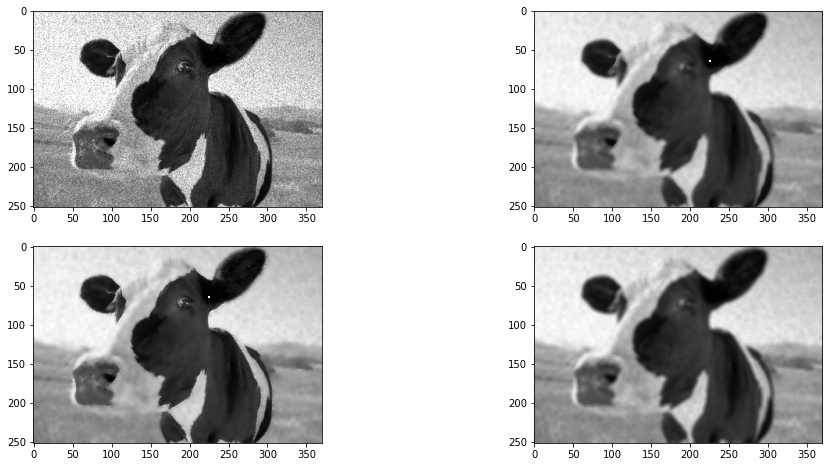

In [387]:
plt.figure(1,figsize=[15,15])
plt.subplot(221).imshow(noise_img,cmap='gray')
plt.subplot(222).imshow(lee,cmap='gray')
plt.subplot(223).imshow(kuan,cmap='gray')
plt.subplot(224).imshow(frost,cmap='gray')
plt.subplots_adjust(top=0.95, bottom=0.55, left=0.10, right=0.95)
plt.show()

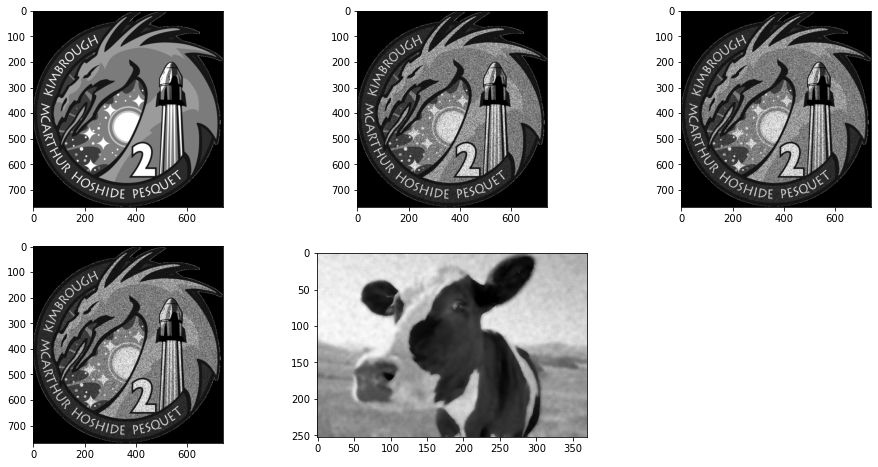

In [145]:
# plt.figure(1,figsize=[15,15])
# plt.subplot(231).imshow(img,cmap='gray')
# plt.subplot(232).imshow(noise_img,cmap='gray')
# plt.subplot(233).imshow(lee,cmap='gray')
# plt.subplot(234).imshow(kuan,cmap='gray')
# plt.subplot(235).imshow(frost,cmap='gray')
# plt.subplots_adjust(top=0.95, bottom=0.55, left=0.10, right=0.95)
# plt.show()

array([238.66666667, 225.33333333, 228.46666667, ..., 142.29166667,
       143.25      , 150.125     ])

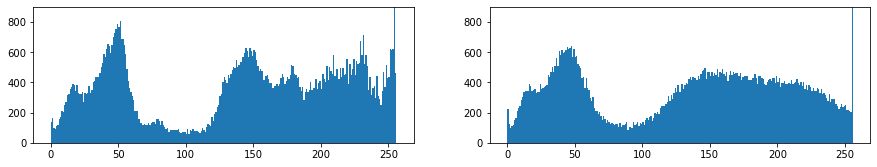

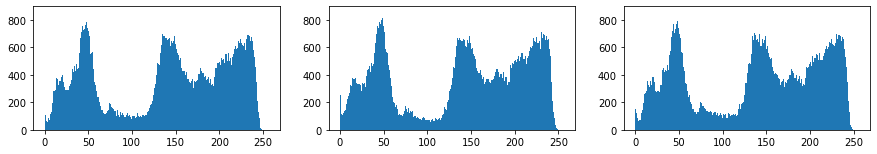

In [381]:
plt.figure(1,figsize=[15,2.5])
plt.subplot(121).hist(img.ravel(),256,[0,256])
plt.ylim(0, 900)
plt.subplot(122).hist(noise_img.ravel(),256,[0,256])
plt.ylim(0, 900)
plt.figure(2,figsize=[15,5])
plt.subplot(234).hist(lee.ravel(),256,[0,256])
plt.ylim(0, 900)
plt.subplot(235).hist(kuan.ravel(),256,[0,256])
plt.ylim(0, 900)
plt.subplot(236).hist(frost.ravel(),256,[0,256])
plt.ylim(0, 900)
plt.show()

<h1>Otros intentos

In [13]:
# def lee_filter(img, size):
#     img_mean = uniform_filter(img, (size, size))
#     img_sqr_mean = uniform_filter(img**2, (size, size))
#     img_variance = img_sqr_mean - img_mean**2
#     overall_variance = variance(img)
#     img_weights = img_variance**2 / (img_variance**2 + overall_variance**2)
#     img_output = img_mean + img_weights * (img - img_mean)
#     return img_output

In [14]:
#lee_img =lee_filter(noise_img,4)

In [15]:
#plt.figure(1,figsize=[15,15])
#plt.subplot(131).imshow(img,cmap='gray')
#plt.subplot(132).imshow(noise_img,cmap='gray')
#plt.subplot(133).imshow(lee_img,cmap='gray')

In [16]:
#plt.figure(1,figsize=[15,5])
#plt.subplot(131).hist(img.ravel(),256,[0,256])
#plt.ylim(0, 900)
#plt.subplot(132).hist(noise_img.ravel(),256,[0,256])
#plt.ylim(0, 900)
#plt.subplot(133).hist(lee_img.ravel(),256,[0,256])
#plt.ylim(0, 900)
#plt.show()

In [17]:
# def kuan_filter(img, size):
#     img_mean = uniform_filter(img, (size, size))  #VALOR MEDIO CORRESPONDIENTE A LA VENTANA
#     img_sqr_mean = uniform_filter(img**2, (size, size))
#     img_variance = img_sqr_mean - img_mean**2     #ESTIMACION DE LA VARIANZA DE LA IMAGEN ORIGINAL EN LA VENTANA
#     L = (np.std(img)/np.mean(img))**2
#     img_variance_denoise = (L*img_variance-img_mean**2)/(L+1)
#     img_output = img_mean + (img_variance_denoise*(img-img_mean))/(img_variance_denoise+(img_mean+img_variance_denoise)/L)
#     return img_output

In [18]:
# plt.figure(1,figsize=[15,15])
# plt.subplot(131).imshow(img,cmap='gray')
# plt.subplot(132).imshow(noise_img,cmap='gray')
# plt.subplot(133).imshow(kuan_filter(noise_img,1),cmap='gray')

<h1>SEGUNDO PUNTO</h1>Implementar, en OpenCV, cinco de las técnicas de estimación del nivel de ruido vistas en clase.

<h2>Relación señal a ruido (SNR)

In [29]:
from skimage.metrics import peak_signal_noise_ratio

SNR_1=np.mean(noise_img)/np.std(noise_img)
SNR_2=mean(noise_img)/standard_deviation(noise_img)
SNR_1,SNR_2,peak_signal_noise_ratio(img,noise_img)

(1.7541464432475704, 1.7541464432475704, 19.158888401478357)

In [22]:
def signaltonoise(Arr, axis=None, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, me/sd)

In [24]:
signaltonoise(lee).mean()

1.9070510472193456

In [36]:
SNR_n=0
SNR_d=0
for i in range(img.shape[0]-1):
    for j in range(img.shape[1]-1):
        Value_n = float((img[i,j])**2)
        SNR_n = float(SNR_n + Value_n)
        Value_d =float((float(img[i,j])-float(noise_img[i,j]))**2)
        SNR_d = float(SNR_d + Value_d)

print(10*np.log10(SNR_n/SNR_d))        

15.080747214060422


<h2>Número equivalente de vistas (ENL)

In [27]:
ENL=np.mean(img)**2/np.std(img)
ENL

257.33200695839474

<h2>Indice de supresión de speckle (SSI)

In [127]:
#SSI
print((np.sqrt(np.std(lee))/np.mean(lee))*(np.mean(noise_img)/np.sqrt(np.std(noise_img))))
print((np.sqrt(np.std(kuan))/np.mean(kuan))*(np.mean(noise_img)/np.sqrt(np.std(noise_img))))
print((np.sqrt(np.std(frost))/np.mean(frost))*(np.mean(noise_img)/np.sqrt(np.std(noise_img))))

0.9595868120085664
0.9584702553885568
0.9743666399626414


<h2>Indice de preservado de la media y supresión del ruido speckle (SMPI)

In [130]:
def SMPI(img_rui,img_fil):
    Mo=1+np.abs(np.mean(img_rui)-np.mean(img_fil))
    SMPI_v = Mo*np.sqrt(np.std(img_fil)/np.std(img_rui))
    return SMPI_v

In [132]:
print(SMPI(noise_img,lee))
print(SMPI(noise_img,kuan))
print(SMPI(noise_img,frost))

1.1160144945340016
1.0531747152694144
1.5881084289373162


<h2>Factor de calidad (Q)

In [134]:
def Qfactor(img,img_fil,enl):
    ys= np.mean(img)-np.abs(np.mean(img)-np.mean(img_fil))
    Q=(ys**2)/(enl*np.std(img_fil))
    return Q

In [137]:
Qfactor(img,lee,ENL)

1.01332686485396

<h1>TERCER PUNTO</h1>Evaluar el desempeño de los filtros implementados (estimar el nivel de ruido en las imágenes antes y después de filtradas), al ser aplicados sobre imágenes reales y sobre imágenes sintéticas (creadas artificialmente), con
diferentes niveles de ruido multiplicativo.